In [1]:
#!/usr/bin/env python
import traceback,logging,os,signal,time,gzip,StringIO,logging.handlers,re,sys,requests, mysql.connector, json
import ftplib
from datetime import tzinfo, timedelta, datetime

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

import sqlite3 as lite
from dateutil.parser import parse
import collections

con=lite.connect('citibike.db')
cur = con.cursor()

%matplotlib inline

In [2]:
r = requests.get('http://www.citibikenyc.com/stations/json')

df = json_normalize(r.json()['stationBeanList'])

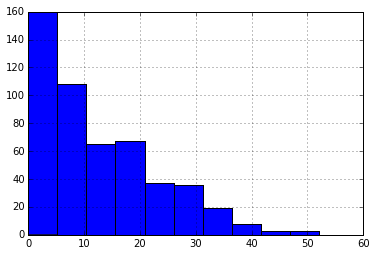

In [3]:
df['availableBikes'].hist()
plt.show()

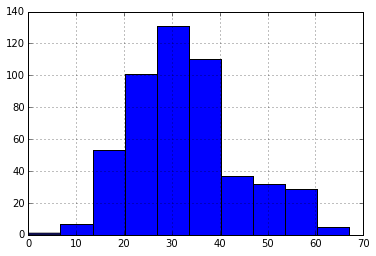

In [4]:
df['totalDocks'].hist()
plt.show()

In [5]:
df.columns.values

array([u'altitude', u'availableBikes', u'availableDocks', u'city', u'id',
       u'landMark', u'lastCommunicationTime', u'latitude', u'location',
       u'longitude', u'postalCode', u'stAddress1', u'stAddress2',
       u'stationName', u'statusKey', u'statusValue', u'testStation',
       u'totalDocks'], dtype=object)

In [6]:
df

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,8,31,,72,,2016-02-03 04:51:52 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,17,14,,79,,2016-02-03 04:50:05 AM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,31
2,,11,15,,82,,2016-02-03 04:50:27 AM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,26
3,,27,35,,83,,2016-02-03 04:49:51 AM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,6,32,,116,,2016-02-03 04:52:10 AM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,38
5,,11,8,,119,,2016-02-03 04:50:20 AM,40.696089,,-73.978034,,Park Ave & St Edwards St,,Park Ave & St Edwards St,1,In Service,False,19
6,,10,9,,120,,2016-02-03 04:49:12 AM,40.686768,,-73.959282,,Lexington Ave & Classon Ave,,Lexington Ave & Classon Ave,1,In Service,False,19
7,,23,8,,127,,2016-02-03 04:52:31 AM,40.731724,,-74.006744,,Barrow St & Hudson St,,Barrow St & Hudson St,1,In Service,False,31
8,,10,20,,128,,2016-02-03 04:52:03 AM,40.727103,,-74.002971,,MacDougal St & Prince St,,MacDougal St & Prince St,1,In Service,False,30
9,,0,44,,137,,2016-02-03 04:52:24 AM,40.761628,,-73.972924,,E 56 St & Madison Ave,,E 56 St & Madison Ave,1,In Service,False,44


In [7]:
df[['statusValue','statusKey']].drop_duplicates()

,statusValue,statusKey
0,In Service,1
221,Not In Service,1
378,Not In Service,3


In [8]:
df.dtypes

altitude                  object
availableBikes             int64
availableDocks             int64
city                      object
id                         int64
landMark                  object
lastCommunicationTime     object
latitude                 float64
location                  object
longitude                float64
postalCode                object
stAddress1                object
stAddress2                object
stationName               object
statusKey                  int64
statusValue               object
testStation                 bool
totalDocks                 int64
dtype: object

In [9]:
# total in-service stations
total_in_service = len(df[df.statusKey == 1])
print total_in_service

503


In [10]:
# total not-in-service stations
total_not_in_service = len(df[df.statusKey == 3])
print total_not_in_service

3


In [11]:
# mean available bikes
df['availableBikes'].mean()

12.57312252964427

In [12]:
# median available bikes
df['availableBikes'].median()

10.0

In [13]:
df[df.statusKey == 3]['availableBikes']
# It does not change because the available bikes account to 0 when the dock is not in service.

378    0
494    0
499    0
Name: availableBikes, dtype: int64

In [14]:
#extract the column from the DataFrame and put them into a list
station_ids = df['id'].tolist() 

print station_ids

#add the '_' to the station name and also add the data type for SQLite
station_ids = ['_' + str(x) + ' INT' for x in station_ids]

print station_ids

[72, 79, 82, 83, 116, 119, 120, 127, 128, 137, 143, 144, 146, 147, 150, 151, 152, 153, 157, 160, 161, 164, 167, 168, 173, 174, 195, 212, 216, 217, 223, 224, 225, 228, 229, 232, 233, 236, 237, 238, 239, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 270, 274, 275, 276, 278, 279, 280, 281, 282, 284, 285, 289, 291, 293, 295, 296, 297, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 334, 335, 336, 337, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 372, 373, 375, 376, 377, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 405, 406, 407, 408, 409, 410, 411, 412, 414, 415, 416, 417, 418, 419, 420, 421, 422, 426, 427, 428, 430, 432

In [15]:
def keywithmaxval(d):
    """Find the key with the greatest value"""
    return max(d, key=lambda k: d[k])


The most active station is station id 301 at E 2 St & Avenue B latitude: 40.72217444 longitude: -73.98368779 
With 37 bicycles coming and going in the hour between 2016-02-03T04:31:10 and 2016-02-03T04:52:29


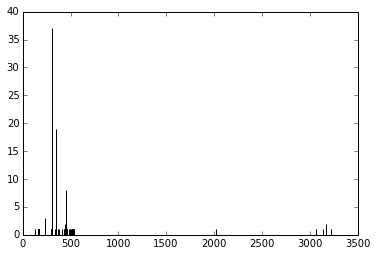

In [17]:
df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time",con,index_col='execution_time')

hour_change = collections.defaultdict(int)
for col in df.columns:
    station_vals = df[col].tolist()
    station_id = col[1:] #trim the "_"
    station_change = 0
    for k,v in enumerate(station_vals):
        if k < len(station_vals) - 1:
            station_change += abs(station_vals[k] - station_vals[k+1])
    hour_change[int(station_id)] = station_change #convert the station id back to integer

# assign the max key to max_station
max_station = keywithmaxval(hour_change)

cur.execute("SELECT id, stationname, latitude, longitude FROM citibike_ref WHERE id = ?", (max_station,))
data = cur.fetchone()
print("The most active station is station id %s at %s latitude: %s longitude: %s " % data)
print("With %d bicycles coming and going in the hour between %s and %s" % (
    hour_change[max_station],
    datetime.fromtimestamp(int(df.index[0])).strftime('%Y-%m-%dT%H:%M:%S'),
    datetime.fromtimestamp(int(df.index[-1])).strftime('%Y-%m-%dT%H:%M:%S'),
))

plt.bar(hour_change.keys(), hour_change.values())
plt.show()